# Import Library

In [25]:
# Enable inline plotting for Jupyter Notebooks
%matplotlib inline

# Import necessary libraries for plotting and data manipulation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import Darts library components for time series processing and modeling
from statsmodels.tsa.seasonal import STL
from darts.dataprocessing.transformers import Scaler  
from darts.models import RNNModel, TCNModel, ARIMA 
from darts.metrics import mape, rmse, r2_score  
from darts.utils.statistics import check_seasonality
from darts.utils.timeseries_generation import datetime_attribute_timeseries  
from darts import TimeSeries  

# Import time module for tracking execution duration
import time

# Suppress warnings to keep output clean
import warnings
warnings.filterwarnings("ignore")

# Disable logging messages at the CRITICAL level or lower
import logging
logging.disable(logging.CRITICAL)

# Suppress Darts logging
logging.getLogger("darts").setLevel(logging.CRITICAL)

# Analyze Data

In [26]:
# Load data and convert to TimeSeries object
df = pd.read_csv('dataset/vietnam_electricity_demand.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
ts = TimeSeries.from_dataframe(df, value_cols='Demand')

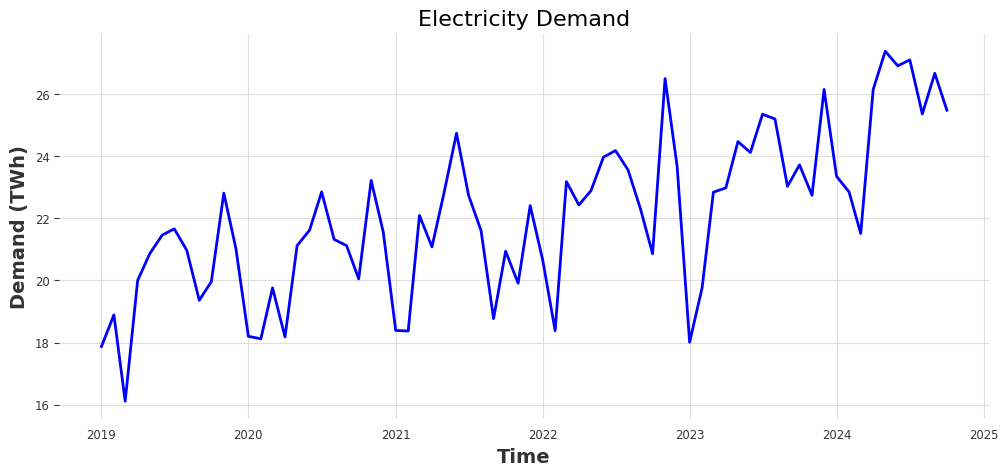

In [27]:
# Plot the observations
plt.figure(figsize=(12, 5))
ts.plot(color='blue')
plt.legend().set_visible(False)
plt.title('Electricity Demand', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Demand (TWh)', fontsize=14)
plt.show()

In [28]:
# Split training vs validation datasets
FC_START = "20221201"   
train, val = ts.split_after(pd.Timestamp(FC_START))

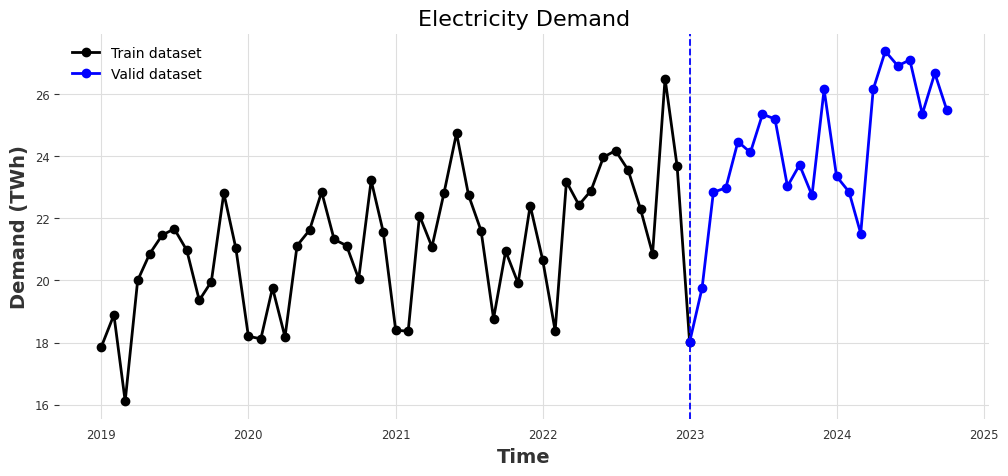

In [29]:
# Plot the division between training and validation datasets
plt.figure(figsize=(12, 5))

split_point = int(len(ts) - len(val))  
split_time = ts.time_index[split_point]

ts_first_half = ts[:split_point + 1]
ts_second_half = ts[split_point:]

ts_first_half.plot(label='Train dataset', marker='o', color='black')
ts_second_half.plot(label='Valid dataset', marker='o', color='blue')

plt.axvline(x=split_time, color='blue', linestyle='--')

plt.title('Electricity Demand', fontsize=16)
plt.legend()
plt.xlabel('Time', fontsize=14)
plt.ylabel('Demand (TWh)', fontsize=14)
plt.show()

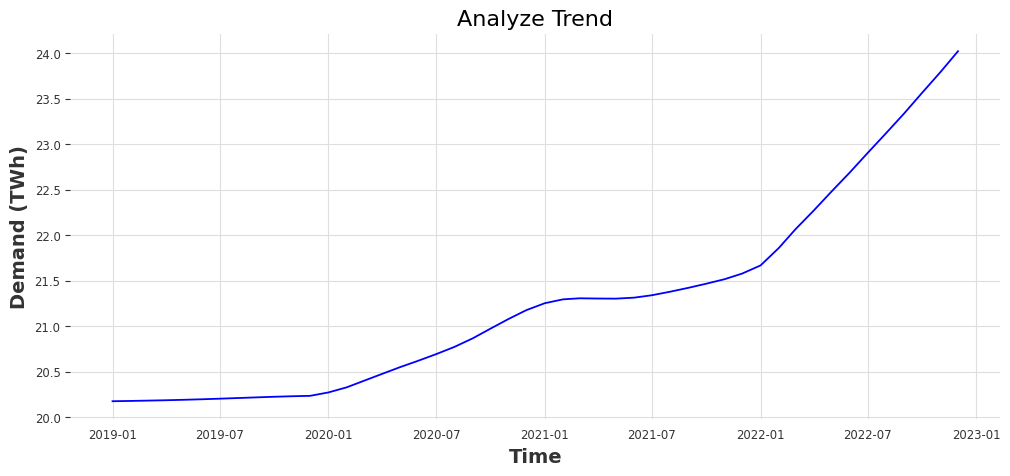

In [30]:
# Analyze Trend
train_df = train.pd_dataframe()
stl = STL(train_df['Demand'])  
result = stl.fit()
plt.figure(figsize=(12, 5))
plt.plot(result.trend, color='blue')
plt.title('Analyze Trend', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Demand (TWh)', fontsize=14)
plt.show()

is seasonal? : True
periodicity (months) : 7.0
periodicity (~years) : 0.6


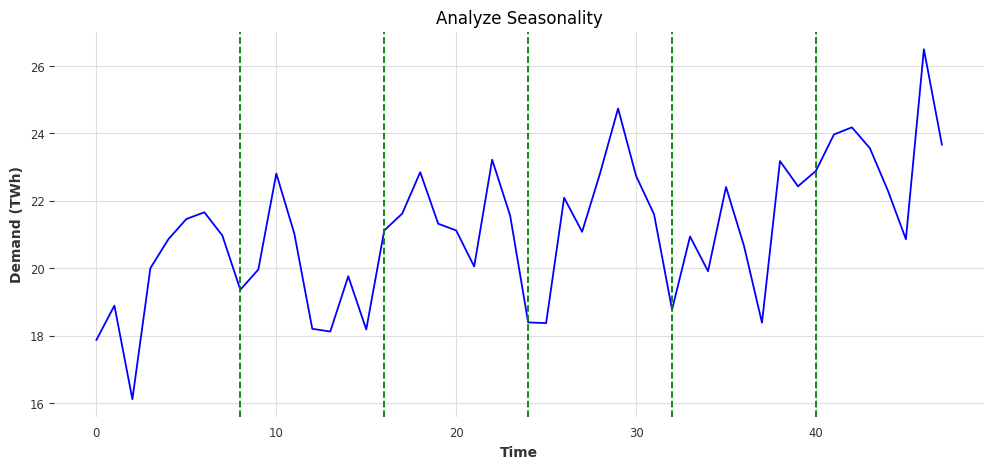

In [32]:
# Analyze seasonality
is_seasonal, periodicity = check_seasonality(train, max_lag=12)
dict_seas = {
    "is seasonal?": is_seasonal, 
    "periodicity (months)": f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'
}
_ = [print(k, ":", v) for k, v in dict_seas.items()]

# Plot the entire time series, concatenating the cycles together
n_periods = int(len(train) / periodicity)  
periods = np.array_split(train.values().flatten(), n_periods)  
combined_periods = np.concatenate(periods)
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(combined_periods)), combined_periods, color='blue')
for i in range(1, len(periods)):
    plt.axvline(x=len(np.concatenate(periods[:i])), color='green', linestyle='--')
plt.title('Analyze Seasonality')
plt.xlabel('Time')
plt.ylabel('Demand (TWh)')
plt.legend()
plt.show()

In [33]:
# Normalize the time series
trf = Scaler()
train_trf = trf.fit_transform(train)
val_trf = trf.transform(val)
ts_trf = trf.transform(ts)

In [34]:
train_trf

<TimeSeries (DataArray) (Date: 48, component: 1, sample: 1)> Size: 384B
array([[[0.16939365]],

       [[0.26756497]],

       [[0.        ]],

       [[0.37439846]],

       [[0.45717036]],

       [[0.51491819]],

       [[0.53416747]],

       [[0.46775746]],

       [[0.31280077]],

       [[0.3705486 ]],

...

       [[0.68046198]],

       [[0.60827719]],

       [[0.65255053]],

       [[0.75649663]],

       [[0.77670837]],

       [[0.71703561]],

       [[0.59576516]],

       [[0.45717036]],

       [[1.        ]],

       [[0.72762271]]])
Coordinates:
  * Date       (Date) datetime64[ns] 384B 2019-01-01 2019-02-01 ... 2022-12-01
  * component  (component) object 8B 'Demand'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [35]:
# Load the weather data from a CSV file
weather_df = pd.read_csv('dataset/weather_data.csv')

month_series = datetime_attribute_timeseries(ts, attribute='month', one_hot=True)

# Convert the TimeSeries object into a DataFrame
month_series_df = month_series.pd_dataframe()

month_series_df['Month'] = month_series_df.index.month  # Extracts the month from the datetime index

# Ensure the 'Month' column in weather_df is of integer type
weather_df['Month'] = weather_df['Month'].astype(int)

weather_covariates = weather_df[['Month', 'Temp_max_North', 'Temp_min_North', 'Humi_North', 'Rain_North', 'Rain_Days_North', 
                                 'Temp_max_Central', 'Temp_min_Central', 'Humi_Central', 'Rain_Central', 'Rain_Days_Central',
                                 'Temp_max_South', 'Temp_min_South', 'Humi_South', 'Rain_South', 'Rain_Days_South']]

# Merge the month data and weather covariates on the 'Month' column using a left join
merged_covariates = pd.merge(month_series_df, weather_covariates, on='Month', how='left')

# Create a new 'Date' column in merged_covariates from the index of month_series_df
merged_covariates['Date'] = month_series_df.index

# Set 'Date' as the index of merged_covariates
merged_covariates.set_index('Date', inplace=True)

In [36]:
merged_covariates

,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,Temp_max_Central,Temp_min_Central,Humi_Central,Rain_Central,Rain_Days_Central,Temp_max_South,Temp_min_South,Humi_South,Rain_South,Rain_Days_South
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32,21.0,86.0,0.0,0,25,19.0,61.5,0.0,0
2019-02-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24,19.5,84.5,0.0,0,34,23.3,58.5,0.0,0
2019-03-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28,22.0,83.0,24.0,2,34,23.0,74.0,13.8,1
2019-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31,24.0,82.0,30.6,2,35,25.0,63.0,10.8,0
2019-05-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,33,25.0,80.0,63.0,3,34,24.0,70.0,66.5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,35,26.0,73.0,55.0,3,33,23.0,75.0,114.0,7
2024-07-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,34,26.0,74.0,82.9,5,32,23.0,81.1,13.8,1
2024-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,34,25.0,80.3,114.0,6,32,23.0,80.0,101.0,7


In [37]:
# The DataFrame has combined month and weather information
covariates_ts = TimeSeries.from_dataframe(
    merged_covariates, 
    value_cols=merged_covariates.columns.difference(['Date', 'Month'])  
)
scaler = Scaler()
covariates_ts_scaled = scaler.fit_transform(covariates_ts)
covariates = covariates_ts_scaled

In [38]:
# # No weather data available for this example, so we will use the month data only

# # Derive the month from the date strings
# month_series = datetime_attribute_timeseries(ts, attribute='month', one_hot=True)
# scaler_month = Scaler()
# covariates = scaler_month.fit_transform(month_series)

# Run the Models

In [39]:
def fit_RNN(model, flavor):
    t_start =  time.perf_counter()
    print("\nbeginning the training of the {0}:".format(flavor))

    res = model.fit(train_trf,
             future_covariates=covariates,
             val_series=val_trf,
             val_future_covariates=covariates,
             verbose=False)

    res_time = time.perf_counter() - t_start
    print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')

    return res

In [40]:
def plot_fitted(pred, act, model_name):
    act2 = act.slice(act.start_time(), pred.end_time())
    split_point = int(len(act) - len(pred))  
    split_time = act2.time_index[split_point]
    act2_first_half = act2[:split_point + 1]
    act2_second_half = act2[split_point:]

    plt.figure(figsize=(12, 5))
    act2_first_half.plot(label='train', marker='o', color='black')
    act2_second_half.plot(label='valid', marker='o', color='blue')
    pred.plot(label='prediction', marker='o', color='green')
    plt.axvline(x=split_time, color='blue', linestyle='--')

    plt_title = "Model: {0}"
    plt.title(plt_title.format(model_name) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend()
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Demand (TWh)', fontsize=14)
    plt.show()

In [41]:
def accuracy_metrics(pred, act):
    act2 = act.slice_intersect(pred)
    pred2 = pred.slice_intersect(act2)

    resid = pred2 - act2
    sr = resid.pd_series()
    sa = act2.pd_series()
    res_mape = mape(pred2, act2)

    res_r2 = r2_score(act2, pred2)

    res_rmse = rmse(pred2, act2)
    res_pe = sr / sa
    n_act = len(act2)
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)     

    res_accuracy = {
        "MAPE":res_mape,"RMSPE":res_rmspe, "RMSE":res_rmse, 
        "-R squared":-res_r2}
    return res_accuracy

In [42]:
def run_RNN(flavor):
    if flavor == "RNN":
        model_RNN = RNNModel(
            model=flavor,
            model_name=flavor + str(" RNN"),
            input_chunk_length=periodicity,
            output_chunk_length = 1,
            training_length=periodicity+1,
            hidden_dim=170, 
            batch_size=64,
            n_epochs=150, 
            dropout=0.2,
            optimizer_kwargs={'lr': 0.001}, 
            random_state=42,
            force_reset=True)
    elif flavor == "GRU":
            model_RNN = RNNModel(
            model=flavor,
            model_name=flavor + str(" RNN"),
            input_chunk_length=periodicity,
            output_chunk_length = 1,
            training_length=periodicity+1,
            hidden_dim=150, 
            batch_size=64,
            n_epochs=200, 
            dropout=0.4,
            optimizer_kwargs={'lr': 0.001}, 
            random_state=42,
            force_reset=True)
    else:
        model_RNN = RNNModel(
            model=flavor,
            model_name=flavor + str(" RNN"),
            input_chunk_length=periodicity,
            output_chunk_length = 1,
            training_length=periodicity+1,
            hidden_dim=175, 
            batch_size=64,
            n_epochs=184, 
            dropout=0.3,
            optimizer_kwargs={'lr': 0.001}, 
            random_state=42,
            force_reset=True)
        
    # Fit the model
    fit_RNN(model_RNN, flavor)

    # Compute N predictions
    pred = model_RNN.predict(len(val), future_covariates=covariates) 

    # Recover predicted values ​​from normalized data for each individual Time Series
    pred = [trf.inverse_transform(p) for p in pred] if isinstance(pred, list) else trf.inverse_transform(pred)

    # Recover predicted values ​​from normalized data for each individual Time Series
    ts_trf_series = [trf.inverse_transform(t) for t in ts_trf] if isinstance(ts_trf, list) else trf.inverse_transform(ts_trf)

    # Plot predictions vs actual
    plot_fitted(pred, ts_trf_series, flavor)

    # Print accuracy metrics
    res_acc = accuracy_metrics(pred, ts_trf_series)    
    print(flavor + " : ")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return res_acc

In [43]:
def run_TCN():
    model_TCN = TCNModel(
    input_chunk_length=periodicity, 
    output_chunk_length=1, 
    n_epochs=199,
    dropout=0.01,
    dilation_base=3,
    weight_norm=True,
    batch_size=16,
    kernel_size=5,
    num_filters=3,
    optimizer_kwargs={'lr': 0.001},
    log_tensorboard=False,
    force_reset=True,
    random_state=42)

    t_start =  time.perf_counter()
    print("\nbeginning the training of the TCN model")
    model_TCN.fit(
            series=train_trf,
            past_covariates=covariates,
            val_series=val_trf,
            val_past_covariates=covariates,
            verbose=False)
    res_time = time.perf_counter() - t_start
    print("training of the TCN has completed: ", f'{res_time:.2f} sec')

    # Compute N predictions
    pred = model_TCN.predict(len(val), past_covariates=covariates)

    # Recover predicted values ​​from normalized data for each individual Time Series
    pred = [trf.inverse_transform(p) for p in pred] if isinstance(pred, list) else trf.inverse_transform(pred)

    # Recover predicted values ​​from normalized data for each individual Time Series
    ts_trf_series = [trf.inverse_transform(t) for t in ts_trf] if isinstance(ts_trf, list) else trf.inverse_transform(ts_trf)

    # Plot predictions vs actual
    plot_fitted(pred, ts_trf_series, "TCN")

    # Print accuracy metrics
    res_acc = accuracy_metrics(pred, ts_trf_series)    
    print("TCN:")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return res_acc


beginning the training of the LSTM:
training of the LSTM RNN has completed: 7.75 sec


Predicting: |          | 0/? [00:00<?, ?it/s]

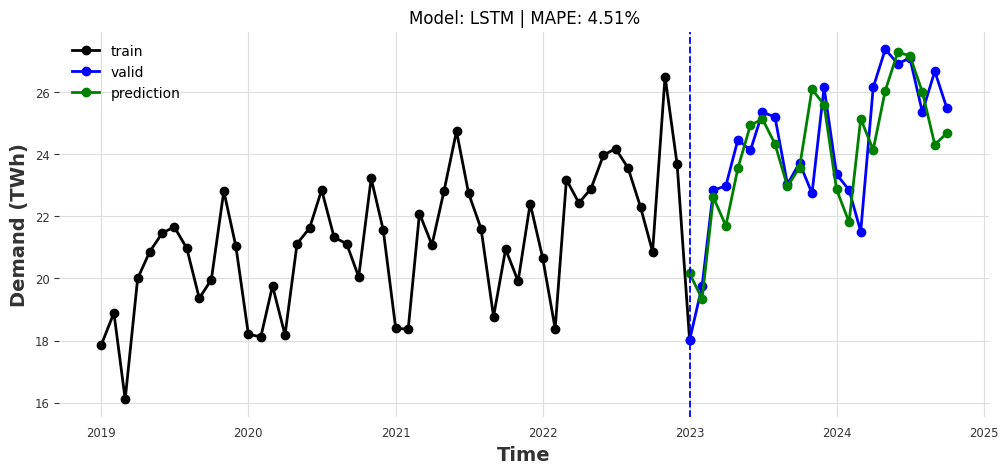

LSTM : 
MAPE : 4.5093
RMSPE : 0.0650
RMSE : 1.4686
-R squared : -0.6038

beginning the training of the GRU:
training of the GRU RNN has completed: 5.92 sec


Predicting: |          | 0/? [00:00<?, ?it/s]

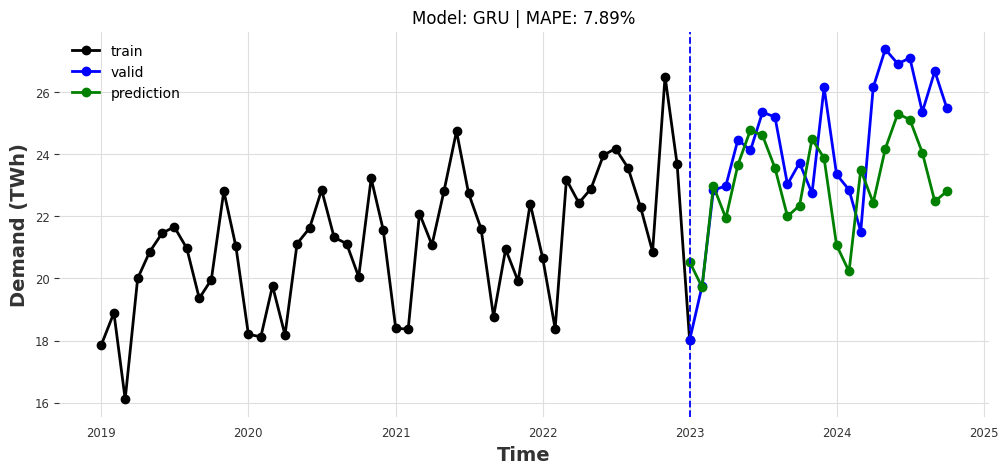

GRU : 
MAPE : 7.8909
RMSPE : 0.0853
RMSE : 2.0899
-R squared : -0.1977

beginning the training of the RNN:
training of the RNN RNN has completed: 3.22 sec


Predicting: |          | 0/? [00:00<?, ?it/s]

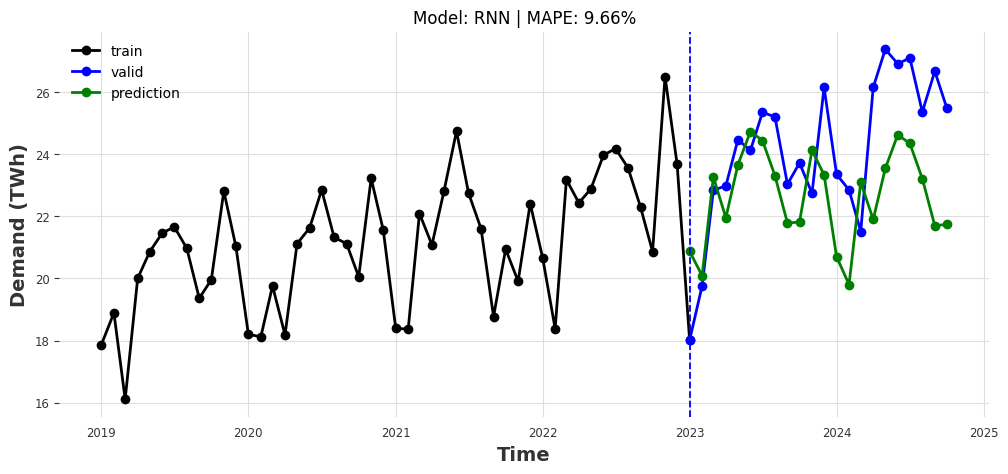

RNN : 
MAPE : 9.6644
RMSPE : 0.1010
RMSE : 2.5026
-R squared : 0.1505

beginning the training of the TCN model
training of the TCN has completed:  5.70 sec


Predicting: |          | 0/? [00:00<?, ?it/s]

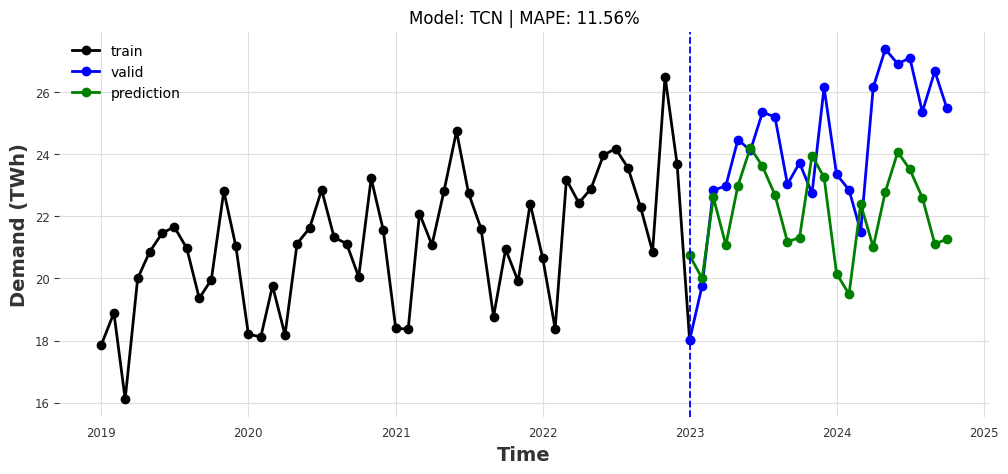

TCN:
MAPE : 11.5610
RMSPE : 0.1169
RMSE : 2.9299
-R squared : 0.5768


In [44]:
# Run TCN and 3 flavors of RNN on the time series:
models = ["LSTM", "GRU", "RNN", "TCN"]

# Call the model setup for each of the models
res_models = [run_TCN() if model == "TCN" else run_RNN(model) for model in models]

Searching for the best ARIMAX parameters...
ARIMAX completed in: 0.61 seconds


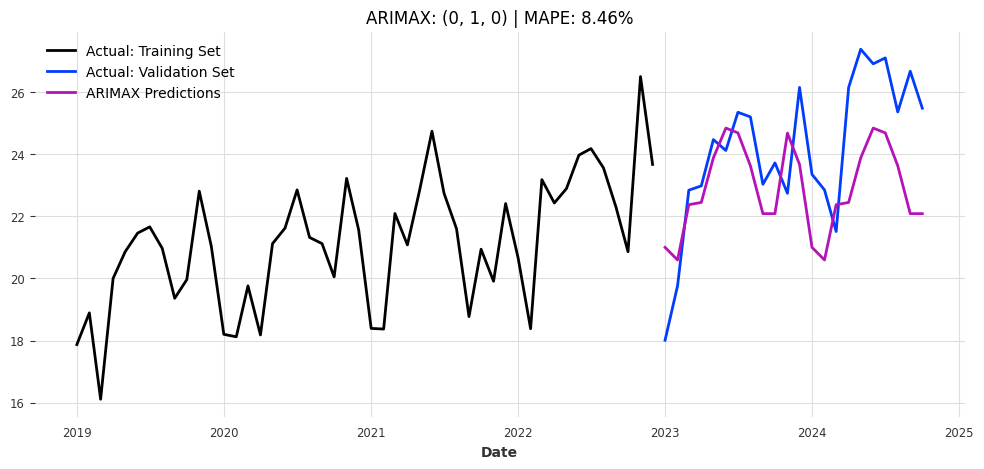

In [45]:
### ARIMAX MODEL ###

# Slice covariates for training and validation sets
train_cov = covariates.slice(train.start_time(), train.end_time())
val_cov = covariates.slice(val.start_time(), val.end_time())

# Initialize search space for (p, d, q) parameters
p_values = range(0, 1)
d_values = range(0, 2)
q_values = range(0, 1)

# Initialize best MAPE and parameters
best_mape = float('inf')
best_params = (0, 0, 0)
t_start = time.perf_counter()

print("Searching for the best ARIMAX parameters...")

# Search for the best (p, d, q) combination
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Initialize and train the ARIMAX model
                model = ARIMA(p=p, d=d, q=q)
                model.fit(train, future_covariates=train_cov)  # Add covariates during training
                pred_arimax = model.predict(len(val), future_covariates=val_cov)  # Predict using covariates
                
                # Calculate MAPE
                res_mape = mape(val, pred_arimax)
                if res_mape < best_mape:
                    best_mape = res_mape
                    best_params = (p, d, q)

            except Exception as e:
                print(f"ARIMAX({p}, {d}, {q}) encountered an error: {e}")
                continue

# Train the best ARIMAX model
best_p, best_d, best_q = best_params
best_arimax_model = ARIMA(p=best_p, d=best_d, q=best_q)
best_arimax_model.fit(train, future_covariates=train_cov)
pred = best_arimax_model.predict(len(val), future_covariates=val_cov)

res_acc = accuracy_metrics(pred, val)

# Display results
val2 = val.slice(val.start_time(), pred.end_time())
plt.figure(figsize=(12, 5))
train.plot(label='Actual: Training Set')
val2.plot(label='Actual: Validation Set')
pred.plot(label='ARIMAX Predictions')
plt.title(f"ARIMAX: {best_params} | MAPE: {mape(pred, val):.2f}%")
plt.legend()

# Time taken and accuracy
res_time = time.perf_counter() - t_start
print(f"ARIMAX completed in: {res_time:.2f} seconds")

In [46]:
# Compare the forecasters's accuracy metrics
dict_models = {
    "LSTM":res_models[0], 
    "GRU":res_models[1],
    "RNN":res_models[2],
    "TCN":res_models[3],
    "ARIMAX":res_acc
}
df_acc = pd.DataFrame.from_dict(dict_models, orient="index").T
pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="green", axis=1).highlight_max(color="blue", axis=1)

,LSTM,GRU,RNN,TCN,ARIMAX
MAPE,4.509252,7.890920,9.664353,11.561025,8.463822
RMSPE,0.064975,0.085283,0.101011,0.116857,0.091137
RMSE,1.468630,2.089941,2.502647,2.929865,2.239708
-R squared,-0.603796,-0.197653,0.150518,0.576847,-0.078538
